# Sample Verification Index Transfers in Grafting - Visualisations

In [1]:
import torch
from matplotlib_venn import venn2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import OrderedDict
import plotly.graph_objects as go
import io
import os
os.chdir('../')

/usr/local/anaconda3/envs/alpha-beta-crown/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Extracted Data from Verifying 1000 samples on pretrained CIFAR CNN-B and provided grafted counterpart

In [2]:
# For unpickling files written on machine with GPU
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
####### EXTRACT FROM SAVED DICTS ########

baseline_path = "VERIFY/CNN-B Example/Baseline/index_results.pkl"

grafted_path = "VERIFY/CNN-B Example/Grafted/index_results.pkl"


path_a = baseline_path
path_b = grafted_path
name_a = "Baseline"
name_b = "Grafted"
with open(path_a, 'rb') as handle:
    results_a = CPU_Unpickler(handle).load()
with open(path_b, 'rb') as handle:
    results_b = CPU_Unpickler(handle).load()

assert results_a.keys() == results_b.keys()

In [4]:
#Calculating source and target lists for streams in visualisation

source_list = []
target_list = []
val_list = []

for i, (_, source) in enumerate(results_a.items()):
    for j, (_, target) in enumerate(results_b.items()):
        v = len(set(source).intersection(set(target)))
        if v > 0:
            source_list.append(i)
            target_list.append(j+4)
            val_list.append(v)
        else:
            source_list.append(i)
            target_list.append(j+4)
            val_list.append(v)


#Printing some stats and calculating the y positions of the nodes to be proportional to their width

n = sum([len(l) for (_,l) in results_a.items()])
print(n)
percentages = [len(l)/n for (_, l) in results_a.items()] + [len(l)/n for (_, l) in results_b.items()]
print(percentages)
print(source_list)
print(target_list)
print(val_list)

half_node_len_list_a = [0]+ [len(l)/2 for (_, l) in results_a.items()]
print(half_node_len_list_a)
pos_list_a = np.cumsum([half_node_len_list_a[i]+half_node_len_list_a[i+1] for i in range(4)]).tolist()
half_node_len_list_b = [0]+ [len(l)/2 for (_, l) in results_b.items()]
pos_list_b = np.cumsum([half_node_len_list_b[i]+half_node_len_list_b[i+1] for i in range(4)]).tolist()
print(pos_list_a + pos_list_b)
pos_list = [round(v/n, 2) for v in pos_list_a+pos_list_b]
pos_list

999
[0.1921921921921922, 0.1941941941941942, 0.36036036036036034, 0.25325325325325326, 0.24624624624624625, 0.18218218218218218, 0.4964964964964965, 0.07307307307307308]
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
[4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7]
[156, 30, 5, 1, 75, 81, 20, 18, 2, 16, 333, 7, 13, 55, 138, 47]
[0, 96.0, 97.0, 180.0, 126.5]
[96.0, 289.0, 566.0, 872.5, 123.0, 337.0, 676.0, 960.5]


[0.1, 0.29, 0.57, 0.87, 0.12, 0.34, 0.68, 0.96]

In [5]:
# define some more variablse relevant for plotting 

opacity = 0.5
skip_color = f'rgba(255,0,0, {opacity})'
attack_color = f'rgba(255, 153, 0, {opacity})'
verify_color = f'rgba(149, 245, 66, {opacity})'
fail_color = f'rgba(92, 92, 92, {opacity})'
colors = [skip_color, attack_color, verify_color, fail_color]
link_colors = [colors[trgt-4] for trgt in target_list]
ann_x = [-0.05,-0.05, -0.05, -0.05,1.05,1.05,1.05,1.05]
ann_y = [1-pos_list[i] for i in range(len(pos_list))]
labels = ['SK', 'AT', 'VS', 'VF', 'SK_g', 'AT_g', 'VS_g', 'VF_g'] 
annotations = [r'${{{name}}} \; ({{{val}}}\%)$'.format(name = a, val = round(b*100, 2)) for a,b in zip(labels,percentages)]

In [6]:
#Plot transfers

fig = go.Figure(data=[go.Sankey(
    textfont=dict(color="rgba(0,0,0,0)", size=1),
    node = dict(
      pad = 10,
      thickness = 20,
      x=[0.15, 0.15, 0.15, 0.15, 0.85, 0.85, 0.85, 0.85],
      y = pos_list,
      line = dict(color = "White", width = 0.5),
      label = labels,
      color =  colors*2
    ),
    link = dict(
      line = dict(color = "White", width = 0.5),
      source = source_list,
      target = target_list,
      value = val_list,
      color = link_colors
  ))])

fig.update_layout(title_text=f"CIFAR CNN-B", font_size=15)

fig.add_annotation(dict(font=dict(color="black",size=14), x=0.10, y=1.08, showarrow=False, text=name_a))
fig.add_annotation(dict(font=dict(color="black",size=14), x=0.92, y=1.13, showarrow=False, text = name_b))
for ann, x, y in zip(annotations, ann_x, ann_y):
    fig.add_annotation(dict(font=dict(color="black",size=12), x=x, y=y, showarrow=False, text=ann))
fig.show()
fig.write_image("graphics/sankey_test.png", scale = 8)

/var/folders/z5/yqd1shk93k5750y70gcq3tgw0000gn/T/ipykernel_34194/732774106.py:17: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



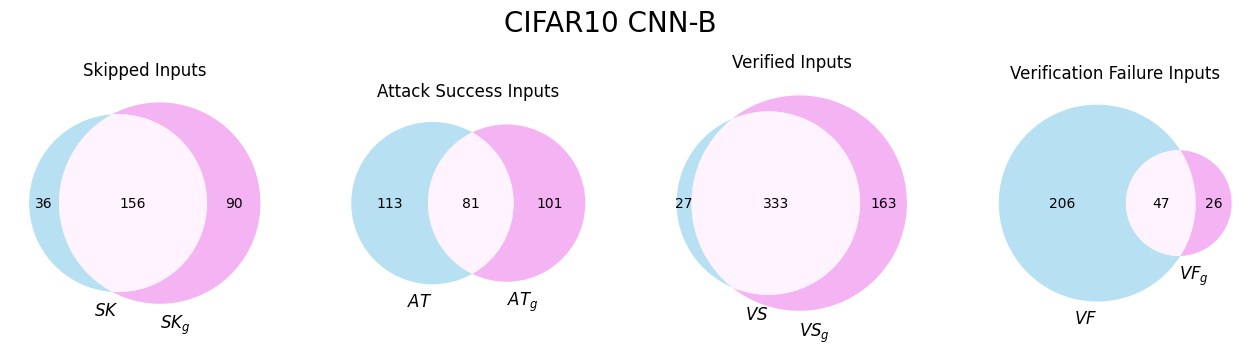

In [7]:
#Venn Plot 

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axes[0].set_title("Skipped Inputs")
venn2([set(results_a['skipped_examples']), set(results_b['skipped_examples'])], set_labels = (r'$SK$', r'$SK_g$'), ax = axes[0], set_colors=('skyblue', 'violet'), alpha = 0.6)

axes[1].set_title("Attack Success Inputs")
venn2([set(results_a['attack_successes']), set(results_b['attack_successes'])], set_labels = (r'$AT$', r'$AT_g$'), ax = axes[1], set_colors=('skyblue', 'violet'), alpha = 0.6)

axes[2].set_title("Verified Inputs")
venn2([set(results_a['verification_success']), set(results_b['verification_success'])], set_labels = (r'$VS$', r'$VS_g$'), ax = axes[2], set_colors=('skyblue', 'violet'), alpha = 0.6)

axes[3].set_title("Verification Failure Inputs")
venn2([set(results_a['verification_failure']), set(results_b['verification_failure'])], set_labels = (r'$VF$', r'$VF_g$'), ax = axes[3], set_colors=('skyblue', 'violet'), alpha = 0.6)

fig.suptitle('CIFAR10 CNN-B', fontsize = 20)
fig.show()
fig.savefig('graphics/venn_sankey_test.pdf')